In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image

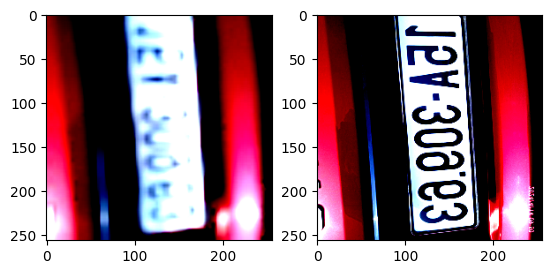

In [ ]:
class LicensePlateDataset(Dataset):
    def __init__(self, LR_folder_path,HR_folder_path, resize_tup):
        super().__init__()
        self.LR_folder_path = LR_folder_path
        self.HR_folder_path = HR_folder_path
        self.resize_tup = resize_tup
        self.transforms = transforms.Compose([
            transforms.Resize(self.resize_tup),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
    def __len__(self):
        if os.listdir(self.LR_folder_path) != os.listdir(self.HR_folder_path):
            raise ValueError("HR image number is not same LR image number!")

        return len(os.listdir(self.LR_folder_path))

    def __getitem__(self, index):
        LR_tail = os.listdir(self.LR_folder_path)
        LR_image = Image.open(os.path.join(self.LR_folder_path,LR_tail[index]))
        LR_image = self.transforms(LR_image)
        HR_tail = os.listdir(self.HR_folder_path)
        HR_image = Image.open(os.path.join(self.HR_folder_path,HR_tail[index]))
        HR_image = self.transforms(HR_image)
        return (LR_image, HR_image)

# Path of image folder
LR_path = r"/content/img_LRsumary"
HR_path = r"/content/img_HRsumary"
Dataset = LicensePlateDataset(LR_path, HR_path, (256,256))

image_test1 = Dataset.__getitem__(1)[0]
image_test1 = image_test1.transpose(2,0)
image_test2 = Dataset.__getitem__(1)[1]
image_test2 = image_test2.transpose(2,0)
plt.subplot(1,2,1)
plt.imshow(image_test1)
plt.subplot(1,2,2)
plt.imshow(image_test2)
plt.show()

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self,in_channel, out_channel):
        super().__init__()
        self.component = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self,x):
        return self.component(x)

skip_connection = []
class Encoder(nn.Module):
    def __init__(self, in_channel, feature_list):
        super().__init__()
        self.feature_list = feature_list
        self.downs = nn.ModuleList()
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottom = DoubleConv(feature_list[-1], feature_list[-1]*2)

        for feature in self.feature_list:
            self.downs.append(DoubleConv(in_channel, feature))
            in_channel = feature

    def forward(self,x):
        for down in self.downs:
            x = down(x)
            # print(x.shape)
            skip_connection.append(x)
            x = self.maxpool2d(x)
        x = self.bottom(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channel, reversed_feature_list):
        """
        Reversed_feature_list[0] == laten_space_channel//2
        """
        super().__init__()
        self.ups=nn.ModuleList()
        self.lastConv2d = nn.Conv2d(reversed_feature_list[-1], out_channel,kernel_size=1)

        for feature in reversed_feature_list:
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2, padding=0))
            self.ups.append(DoubleConv(feature*2, feature))

    def forward(self, x):
        for i in range(0,len(self.ups),2):
            x = self.ups[i](x)

            if x.shape != skip_connection[len(skip_connection)-1-i//2].shape:
                x = TF.resize(x, size=skip_connection[len(skip_connection)-1-i//2].shape[2:])
            x = torch.cat([skip_connection[len(skip_connection)-1-i//2], x],axis=1)

            x = self.ups[i+1](x)
        return self.lastConv2d(x)

feature_list = [64,128,256,512]
reversed_feature_list = feature_list[::-1]
enc = Encoder(3,feature_list)
dec = Decoder(3,reversed_feature_list)
x = torch.rand(1,3,64,64)
out_enc = enc(x)
out_dec = dec(out_enc)
out_dec.shape
model=nn.Sequential(enc,dec)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

31043651

In [ ]:
epochs = 2
device = 'cuda'
loss_fn = nn.MSELoss()

image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)

enc1 = Encoder(3,[64])
dec1 = Decoder(3,[64])
enc1.load_state_dict(torch.load(r'/content/enc1.pth'))
dec1.load_state_dict(torch.load(r"/content/dec1.pth"))
model = nn.Sequential(enc1,dec1)
model.to(device)
optimizer = Adam(model.parameters(),lr=0.0001)
skip_connection = []
for epoch in range(epochs):
  model.train()
  sum_loss = 0
  n=len(dataloader)
  for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        optimizer.zero_grad()
        HR_output = model(LR_image)
        loss = loss_fn(HR_output, HR_image)
        loss.backward()
        optimizer.step()
        sum_loss+=loss
  print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

<ipython-input-4-ade29780994e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc1.load_state_dict(torch.load(r'/content/enc1.pth'))
<ipython-input-4-ade29780994e>:11: Fu

Epoch 1 : Loss 0.047208111733198166
Epoch 2 : Loss 0.045666731894016266


In [ ]:
torch.save(enc1.state_dict(), 'enc1.pth')
torch.save(dec1.state_dict(), 'dec1.pth')

In [ ]:
enc1 = Encoder(3,[64])
dec1 = Decoder(3,[64])
enc1.load_state_dict(torch.load('enc1.pth'))
dec1.load_state_dict(torch.load('dec1.pth'))

<ipython-input-11-bd1a4e187378>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enc1.load_state_dict(torch.load('enc1.pth'))
<ipython-input-11-bd1a4e187378>:4: FutureWarnin

<All keys matched successfully>

In [ ]:
import numpy as np
import cv2


def calculate_psnr(original, compressed):
    # Đảm bảo hai hình ảnh có cùng kích thước
    assert original.shape == compressed.shape, "Hình ảnh phải có cùng kích thước"

    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # PSNR vô cùng nếu không có sai khác

    max_pixel = 4.5  # Giả sử hình ảnh có độ sâu 8-bit
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def calculate_ssim(img1, img2):

    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tách các kênh màu (RGB)
    ssim_values = []
    for i in range(3):  # Duyệt qua 3 kênh màu
        ssim_value = ssim(img1[:, :, i], img2[:, :, i], data_range=img2[:, :, i].max() - img2[:, :, i].min())
        ssim_values.append(ssim_value)

    # Tính SSIM trung bình trên 3 kênh
    return np.mean(ssim_values)

import cv2
import numpy as np

def calculate_nmse(img1, img2):

    # Kiểm tra kích thước ảnh
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tính NMSE
    numerator = np.sum((img1 - img2) ** 2)
    denominator = np.sum(img2 ** 2)
    nmse_value = numerator / denominator if denominator != 0 else float('inf')
    return nmse_value

In [ ]:
import numpy as np
device = 'cuda'
psnr_score = []
ssim_score = []
nmse_score = []
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
model = nn.Sequential(enc1,dec1)
model.to(device)
i=0
for LR_image, HR_image in dataloader:
        if i==500:
          break
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = model(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.detach().cpu().numpy()

        HR_image = HR_image.squeeze(0).permute(1,2,0)
        HR_image = HR_image.detach().cpu().numpy()
        psnr_score.append(calculate_psnr(HR_image,HR_output))
        ssim_score.append(calculate_ssim(HR_image,HR_output))
        nmse_score.append(calculate_nmse(HR_image,HR_output))
        i+=1

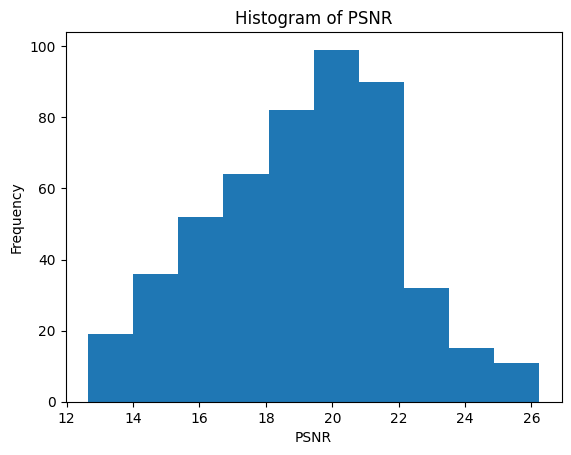

In [ ]:
plt.hist(psnr_score)
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR")
plt.show()

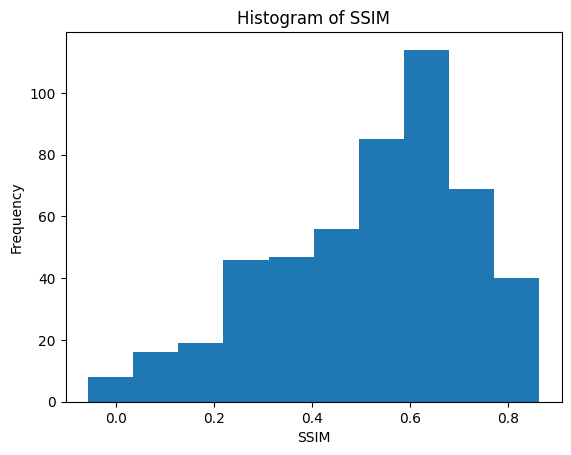

In [ ]:
plt.hist(ssim_score)
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.title("Histogram of SSIM")
plt.show()

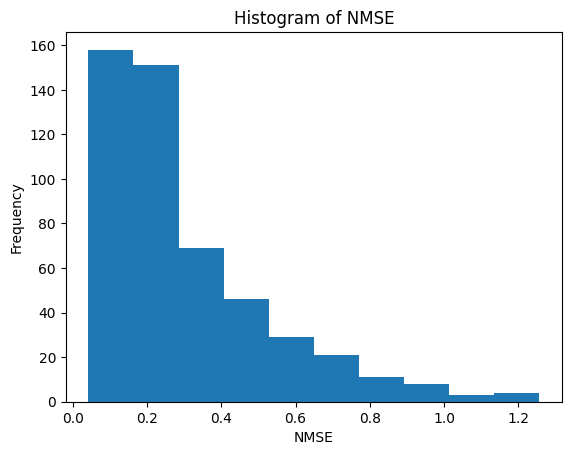

In [ ]:
plt.hist(nmse_score)
plt.xlabel("NMSE")
plt.ylabel("Frequency")
plt.title("Histogram of NMSE")
plt.show()

In [ ]:
import pandas as pd
one_stack_dict = {"METHOD":"1SAE","PSNR":psnr_score, "SSIM":ssim_score,"NMSE":nmse_score}
one_stack_df = pd.DataFrame(one_stack_dict)
one_stack_df.shape

(500, 4)

In [ ]:
one_stack_df.to_csv("1SAE_sau.csv")